<a href="https://colab.research.google.com/github/Summeryuqing01/Neural-Net-Experiments/blob/main/SimpleDNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

**Reporting Functions**


In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

**Preprocess Data**

In [ ]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# encode
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [ ]:
# reshape
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

In [ ]:
# rescale
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [ ]:
# validation
x_train, x_val = x_train_norm[:55000], x_train_norm[55000:]
y_train_encoded, y_val_encoded = y_train_encoded[:55000], y_train_encoded[55000:]

**Experimment 1**

In [ ]:
model1 = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model1.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history1 = model1.fit(
    x_train,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_data=(x_val,y_val_encoded),
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.1",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 10s 4ms/step - loss: 1.9828 - accuracy: 0.2094 - val_loss: 1.8523 - val_accuracy: 0.2756
Epoch 2/200
1719/1719 [==============================] - 6s 4ms/step - loss: 1.8405 - accuracy: 0.2412 - val_loss: 1.7904 - val_accuracy: 0.2700
Epoch 3/200
1719/1719 [==============================] - 6s 3ms/step - loss: 1.8025 - accuracy: 0.2536 - val_loss: 1.7618 - val_accuracy: 0.2784
Epoch 4/200
1719/1719 [==============================] - 6s 4ms/step - loss: 1.7821 - accuracy: 0.2709 - val_loss: 1.7442 - val_accuracy: 0.2810
Epoch 5/200
1719/1719 [==============================] - 6s 3ms/step - loss: 1.7667 - accuracy: 0.2908 - val_loss: 1.7245 - val_accuracy: 0.3136
Epoch 6/200
1719/1719 [==============================] - 7s 4ms/step - loss: 1.7529 - accuracy: 0.3039 - val_loss: 1.7086 - val_accuracy: 0.2986
Epoch 7/200
1719/1719 [==============================] - 6s 4ms/step - loss: 1.7398 - accuracy: 0.3060 - val_loss: 1.6971 - val_a

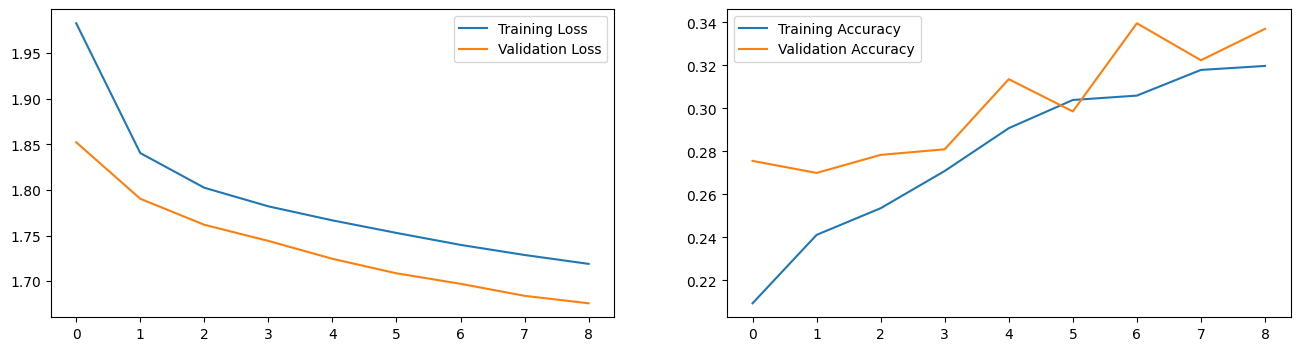

In [ ]:
plot_history(history1)

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model1.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

1875/1875 [==============================] - 3s 2ms/step


(60000, 1)

In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.061  0.2274 0.2189 0.1626 0.     0.1565 0.0043 0.0016 0.1675 0.0002]
The sum of the probabilities is (approximately) 0.9999999403953552


In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]
activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.0,9.0,2.00,1.000,3.000,1.000,4.0,3.000,5.000,3.000,6.0,1.000
act_val_0,3.325,0.847,0.799,3.2,0.0,2.43,3.951,5.212,3.038,0.0,5.445,3.475,7.847,0.0,3.449


<ipython-input-16-ed66a45a3518>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bplot = sns.boxplot(y='act_val_0', x='actual_class',


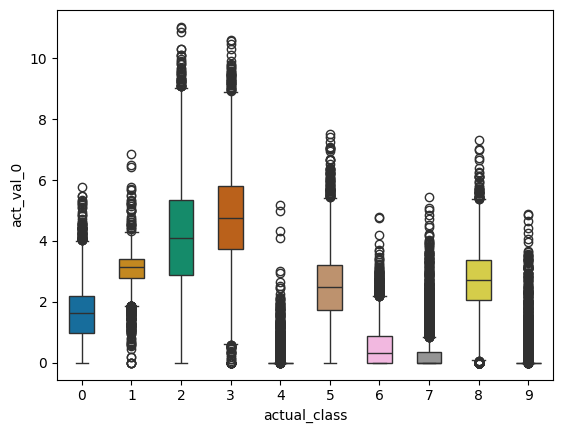

In [ ]:
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.1")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test,pred1)

313/313 [==============================] - 1s 2ms/step - loss: 1.7148 - accuracy: 0.3291
Test acc: 0.329
313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.33      0.48      0.39       980
           1       0.37      0.79      0.50      1135
           2       0.14      0.09      0.11      1032
           3       0.46      0.69      0.55      1010
           4       0.30      0.89      0.44       982
           5       0.18      0.02      0.03       892
           6       0.28      0.14      0.19       958
           7       0.22      0.07      0.11      1028
           8       0.00      0.00      0.00       974
           9       0.25      0.04      0.07      1009

    accuracy                           0.33     10000
   macro avg       0.25      0.32      0.24     10000
weighted avg       0.26      0.33      0.24     10000

Accuracy Score: 0.3291
Root Mean Square Error: 3.4596820663

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Experiment 2**

In [ ]:
model2 = Sequential([
    Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])
model2.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
history2 = model2.fit(
    x_train,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_data=(x_val,y_val_encoded),
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.2",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 8s 4ms/step - loss: 1.6853 - accuracy: 0.4067 - val_loss: 1.4290 - val_accuracy: 0.5030
Epoch 2/200
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3986 - accuracy: 0.5175 - val_loss: 1.3033 - val_accuracy: 0.5502
Epoch 3/200
1719/1719 [==============================] - 6s 4ms/step - loss: 1.3069 - accuracy: 0.5597 - val_loss: 1.2234 - val_accuracy: 0.6090
Epoch 4/200
1719/1719 [==============================] - 6s 3ms/step - loss: 1.2491 - accuracy: 0.5985 - val_loss: 1.1774 - val_accuracy: 0.6266
Epoch 5/200
1719/1719 [==============================] - 6s 4ms/step - loss: 1.2107 - accuracy: 0.6221 - val_loss: 1.1346 - val_accuracy: 0.6636
Epoch 6/200
1719/1719 [==============================] - 6s 3ms/step - loss: 1.1768 - accuracy: 0.6365 - val_loss: 1.0901 - val_accuracy: 0.6706
Epoch 7/200
1719/1719 [==============================] - 6s 4ms/step - loss: 1.1378 - accuracy: 0.6509 - val_loss: 1.0375 - val_ac

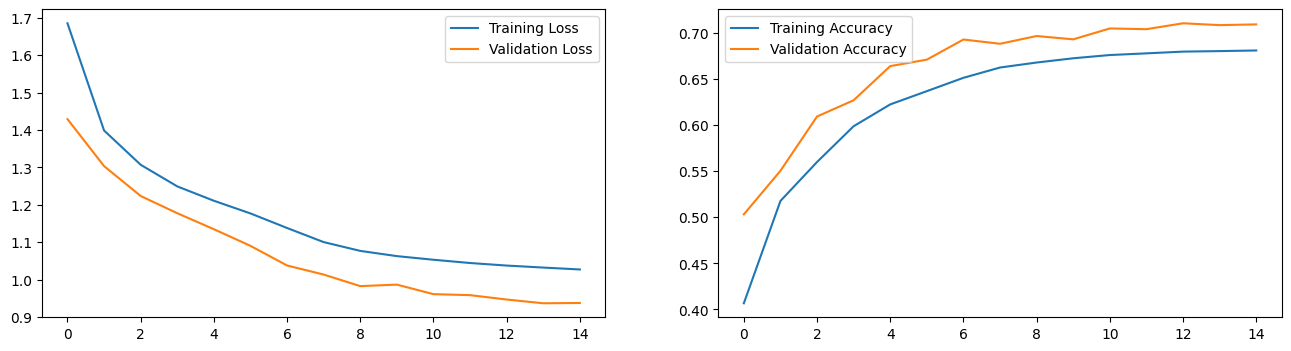

In [ ]:
plot_history(history2)

In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.2")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")
pred2= model.predict(x_test_norm)
pred2=np.argmax(pred2, axis=1)
print_validation_report(y_test,pred2)

313/313 [==============================] - 1s 2ms/step - loss: 1.0088 - accuracy: 0.6877
Test acc: 0.688
313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       980
           1       0.88      0.95      0.91      1135
           2       0.56      0.53      0.55      1032
           3       0.59      0.63      0.61      1010
           4       0.78      0.85      0.82       982
           5       0.51      0.46      0.48       892
           6       0.80      0.86      0.83       958
           7       0.60      0.57      0.58      1028
           8       0.52      0.39      0.45       974
           9       0.68      0.77      0.73      1009

    accuracy                           0.69     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.69      0.68     10000

Accuracy Score: 0.6877
Root Mean Square Error: 2.0479013648

1719/1719 [==============================] - 3s 2ms/step


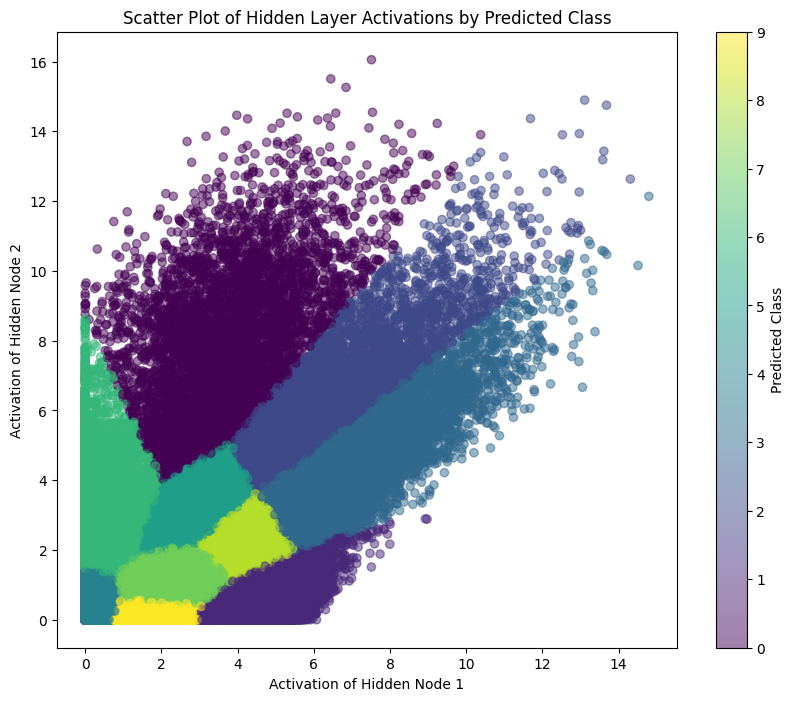

In [ ]:
# Extract activations for the hidden layer
activation_model2 = tf.keras.models.Model(inputs=model2.input,
                                              outputs=model2.layers[0].output)
hidden_activations2 = activation_model2.predict(x_train)

# Predict classes to color-code in the scatter plot
predicted_classes2 = model2.predict(x_train).argmax(axis=1)

# Scatter plot of the two hidden node activations
plt.figure(figsize=(10, 8))
plt.scatter(hidden_activations2[:, 0], hidden_activations2[:, 1], c=predicted_classes2, cmap='viridis', alpha=0.5)
plt.title('Scatter Plot of Hidden Layer Activations by Predicted Class')
plt.xlabel('Activation of Hidden Node 1')
plt.ylabel('Activation of Hidden Node 2')
plt.colorbar(label='Predicted Class')
plt.show()

**Experiment 3**

In [ ]:
model3 = Sequential([
    Dense(input_shape=[784], units=64, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])
model3.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
history3 = model3.fit(
    x_train,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_data=(x_val,y_val_encoded),
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.3",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4016 - accuracy: 0.9088 - val_loss: 0.2265 - val_accuracy: 0.9556
Epoch 2/200
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2485 - accuracy: 0.9461 - val_loss: 0.1879 - val_accuracy: 0.9658
Epoch 3/200
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2099 - accuracy: 0.9547 - val_loss: 0.1667 - val_accuracy: 0.9712
Epoch 4/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1877 - accuracy: 0.9609 - val_loss: 0.1732 - val_accuracy: 0.9676
Epoch 5/200
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1754 - accuracy: 0.9637 - val_loss: 0.1602 - val_accuracy: 0.9706


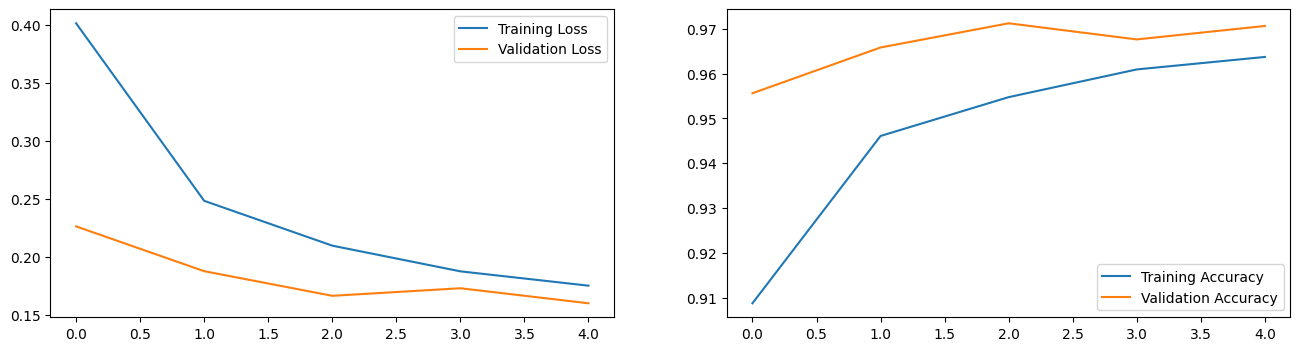

In [ ]:
plot_history(history3)

In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.3")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")
pred3= model.predict(x_test_norm)
pred3=np.argmax(pred3, axis=1)
print_validation_report(y_test,pred3)

313/313 [==============================] - 1s 2ms/step - loss: 0.1791 - accuracy: 0.9621
Test acc: 0.962
313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.98      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.97      0.96      0.96      1010
           4       0.95      0.96      0.96       982
           5       0.97      0.95      0.96       892
           6       0.99      0.94      0.96       958
           7       0.93      0.98      0.95      1028
           8       0.96      0.94      0.95       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Accuracy Score: 0.9621
Root Mean Square Error: 0.8279492738

**Experiment 4**

In [ ]:
from sklearn.decomposition import PCA

# Fit PCA on the training data
pca = PCA(n_components=0.95)
x_train_reduced = pca.fit_transform(x_train.reshape(-1, 784))  # Reshape to 2D array for PCA
x_test_reduced = pca.transform(x_test.reshape(-1, 784))

print(f"Reduced training data shape: {x_train_reduced.shape}")

Reduced training data shape: (55000, 154)


In [ ]:
model4 = Sequential([
    Dense(input_shape=[154], units=64, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])
model4.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
history4 = model4.fit(
    x_train_reduced,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.4",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1547/1547 [==============================] - 6s 3ms/step - loss: 0.4810 - accuracy: 0.8893 - val_loss: 0.2768 - val_accuracy: 0.9364
Epoch 2/200
1547/1547 [==============================] - 5s 3ms/step - loss: 0.2289 - accuracy: 0.9496 - val_loss: 0.2200 - val_accuracy: 0.9538
Epoch 3/200
1547/1547 [==============================] - 5s 4ms/step - loss: 0.1880 - accuracy: 0.9609 - val_loss: 0.1923 - val_accuracy: 0.9598
Epoch 4/200
1547/1547 [==============================] - 5s 3ms/step - loss: 0.1653 - accuracy: 0.9664 - val_loss: 0.1789 - val_accuracy: 0.9629
Epoch 5/200
1547/1547 [==============================] - 6s 4ms/step - loss: 0.1503 - accuracy: 0.9702 - val_loss: 0.1708 - val_accuracy: 0.9633
Epoch 6/200
1547/1547 [==============================] - 5s 4ms/step - loss: 0.1394 - accuracy: 0.9731 - val_loss: 0.1629 - val_accuracy: 0.9651
Epoch 7/200
1547/1547 [==============================] - 6s 4ms/step - loss: 0.1308 - accuracy: 0.9750 - val_loss: 0.1542 - val_ac

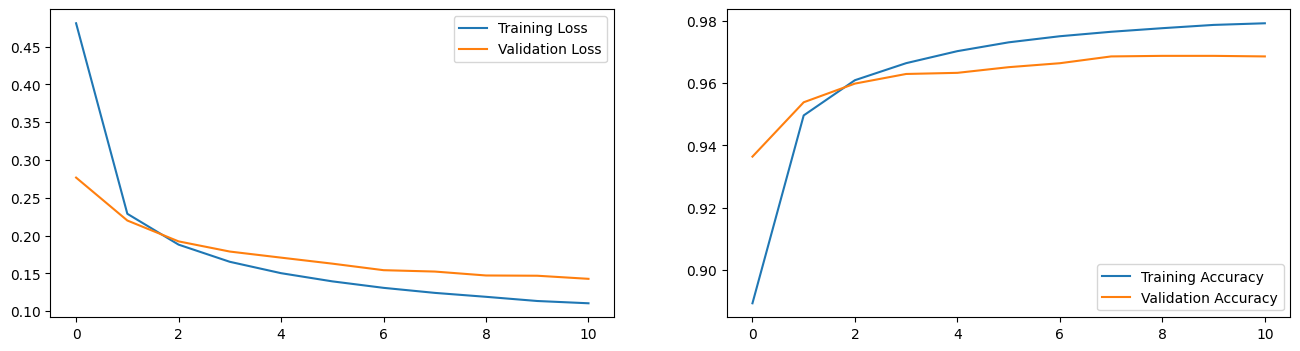

In [ ]:
plot_history(history4)

In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.4")
print(f"Test acc: {model.evaluate(x_test_reduced, y_test_encoded)[1]:.3f}")
pred4= model.predict(x_test_reduced)
pred4=np.argmax(pred4, axis=1)
print_validation_report(y_test,pred4)

313/313 [==============================] - 1s 3ms/step - loss: 17.4752 - accuracy: 0.9587
Test acc: 0.959
313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.89      0.99      0.94      1010
           4       0.97      0.97      0.97       982
           5       0.99      0.92      0.95       892
           6       0.98      0.97      0.97       958
           7       0.99      0.90      0.94      1028
           8       0.94      0.97      0.95       974
           9       0.92      0.95      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Accuracy Score: 0.9587
Root Mean Square Error: 0.826075057

**Experiment 5**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier with the training data
rf.fit(x_train_norm, y_train_encoded)

# Get feature importances
importances = rf.feature_importances_

In [ ]:
# Get the indices of the top 70 features
indices = np.argsort(importances)[::-1][:70]

# Select these top features from the training and test data
x_train_reduced_rf = x_train_norm[:, indices]
x_test_reduced_rf = x_test_norm[:, indices]

In [ ]:
model5 = Sequential([
    Dense(input_shape=[70], units=64, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

model5.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
history5 = model5.fit(
    x_train_reduced_rf,
    y_train_encoded,
    epochs = 200,verbose=1,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras.5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.7496 - accuracy: 0.8020 - val_loss: 0.4893 - val_accuracy: 0.8793
Epoch 2/200
1688/1688 [==============================] - 6s 4ms/step - loss: 0.5322 - accuracy: 0.8633 - val_loss: 0.4198 - val_accuracy: 0.8965
Epoch 3/200
1688/1688 [==============================] - 6s 4ms/step - loss: 0.4685 - accuracy: 0.8798 - val_loss: 0.3844 - val_accuracy: 0.9067
Epoch 4/200
1688/1688 [==============================] - 6s 4ms/step - loss: 0.4288 - accuracy: 0.8904 - val_loss: 0.3565 - val_accuracy: 0.9128
Epoch 5/200
1688/1688 [==============================] - 6s 4ms/step - loss: 0.4018 - accuracy: 0.8977 - val_loss: 0.3442 - val_accuracy: 0.9148
Epoch 6/200
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3812 - accuracy: 0.9017 - val_loss: 0.3361 - val_accuracy: 0.9168
Epoch 7/200
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3657 - accuracy: 0.9066 - val_loss: 0.3194 - val_ac

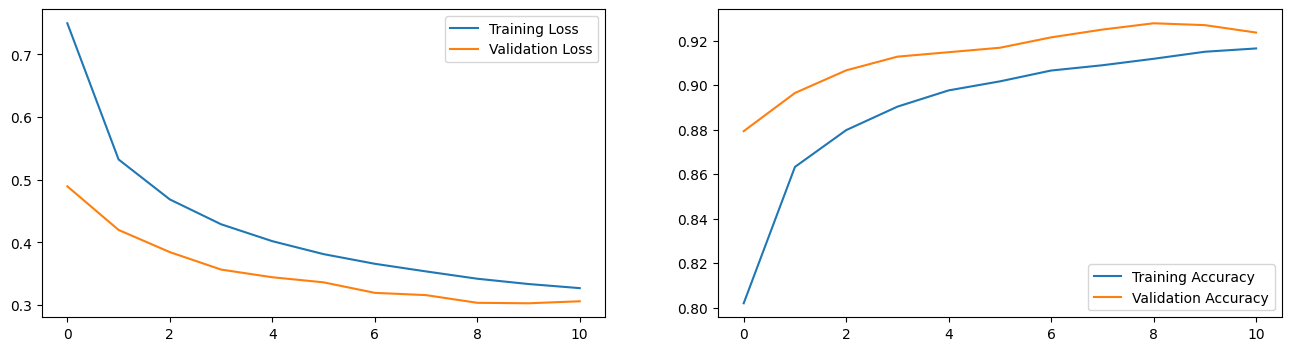

In [ ]:
plot_history(history5)

In [ ]:
model = tf.keras.models.load_model("DNN_model.keras.5")
print(f"Test acc: {model.evaluate(x_test_reduced_rf, y_test_encoded)[1]:.3f}")
pred5= model.predict(x_test_reduced_rf)
pred5=np.argmax(pred5, axis=1)
print_validation_report(y_test,pred5)

313/313 [==============================] - 1s 3ms/step - loss: 0.3349 - accuracy: 0.9159
Test acc: 0.916
313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.88      0.90      1032
           3       0.87      0.93      0.90      1010
           4       0.87      0.94      0.90       982
           5       0.87      0.88      0.87       892
           6       0.95      0.91      0.93       958
           7       0.92      0.92      0.92      1028
           8       0.94      0.87      0.91       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9159
Root Mean Square Error: 1.1682893477

In [ ]:
%%shell
jupyter nbconvert --to html /content/NN_hw1.ipynb

[NbConvertApp] Converting notebook /content/NN_hw1.ipynb to html
[NbConvertApp] Writing 1376602 bytes to /content/NN_hw1.html
